In [159]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

# Set CPU count for numpyro multi-chain multi-thread
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import math
import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit, vmap
import jax.random as jr

import webbpsf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm
from numpyro.infer.util import log_likelihood

from dLuxWebbpsf import NIRCam

def norm(data):
    return data/data.sum()

def toRad(arcsecs):
    return arcsecs * np.pi / (180*3600)

def toArcsec(radians):
    return radians / np.pi * (180*3600)

def sepToXy(x, y, separation, angle):
    dx = separation * np.sin(angle) / 2
    dy = separation * np.cos(angle) / 2
    return (x + dx, y + dy), (x - dx, y - dy)

def xyToSep(x1, y1, x2, y2):
    x0 = (x2 + x1) / 2
    y0 = (y2 + y1) / 2

    dx = (-x2 + x1)
    dy = (-y2 + y1)

    sepr = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dx, dy)
    
    return (x0, y0, sepr, angle)

In [136]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

npix = 56

source_offset_x = toRad(0)
source_offset_y = toRad(0)
offset = np.array([source_offset_x, source_offset_y])
separation = toRad(0.12)
position_angle = 2
flux = 10
contrast = 100

(pri_x, pri_y), (sec_x, sec_y) = sepToXy(source_offset_x, source_offset_y, separation, position_angle)

print(f'primary: {pri_x}, {pri_y}')
print(f'secondary: {sec_x}, {sec_y}')

telescope = NIRCam(filter = "F300M",
                pupil_mask = None,
                coron_mask = None,
                detector = "NRCA5",
                aperture = "NRCA5_FULL_MASK430R",
                fft_oversample=1,
                detector_oversample=4,
                wavefront_downsample=8,
                fov_pixels=npix,
                options=webb_options,
                monochromatic = 4.82792251e-06,
                offset=offset
               )

wavelengths = telescope.filter_wavelengths
weights = telescope.filter_weights

spectrum = dl.Spectrum(wavelengths, weights)

source = dl.BinarySource(wavelengths, separation=separation, position=offset, position_angle=position_angle, contrast=contrast, flux=flux)

telescope = telescope.set(["source"], [source])

INFO:webbpsf:NIRCam aperture name updated to NRCA1_FULL
INFO:webbpsf:NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
INFO:webbpsf:NIRCam aperture name updated to NRCA5_FULL
INFO:webbpsf:NIRCam aperture name updated to NRCA5_FULL_MASK430R
INFO:webbpsf:Creating optical system model:
INFO:poppy:Initialized OpticalSystem: JWST+NIRCam
INFO:poppy:JWST Entrance Pupil: Loaded amplitude transmission from /Users/uqitroit/Dev/optics/webbpsf-data/jwst_pupil_RevW_npix1024.fits.gz


primary: 2.645038996336726e-07, -1.210522078251051e-07
secondary: -2.645038996336726e-07, 1.210522078251051e-07


INFO:poppy:JWST Entrance Pupil: Loaded OPD from /Users/uqitroit/Dev/optics/webbpsf-data/JWST_OTE_OPD_cycle1_example_2022-07-30.fits
INFO:webbpsf:Loading field dependent model parameters from /Users/uqitroit/Dev/optics/webbpsf-data/NIRCam/OPD/field_dep_table_nircam.fits
INFO:webbpsf:Calculating field-dependent OTE OPD at v2 = 1.456 arcmin, v3 = -6.752 arcmin
INFO:poppy:Added pupil plane: JWST Entrance Pupil
INFO:poppy:Added coordinate inversion plane: OTE exit pupil
INFO:poppy:Added pupil plane: NIRCamLWA internal WFE at V2V3=(1.46,-6.75)', near ISIM30
INFO:poppy:Added detector with pixelscale=0.063 and oversampling=4: NIRCam detector
INFO:poppy:Monochromatic calculation requested.


pixel scale: 7.635815477475192e-08


In [137]:
(0.432e-6/6.5)

6.646153846153847e-08

In [138]:
pixscale = 7.635815477475192e-08 * 4

In [139]:
def toPix(value):
    ret = (value / pixscale) + npix/2 - 0.5
    return ret

## Step 2: Make an optical model for optimisation where source will be parametrised.

The solution that they have for this same problem in https://github.com/amerand/CANDID, a popular interferometry data analysis code, is to calculate the likelihood on a grid of xy with other parameters held constant, to identify the best position to start
see that page - scroll down to ‘CHI2MAP’ and ‘FITMAP’

In [140]:
@jit
def model_optics_jit():
    return telescope.model()

In [141]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")

Modelling optics...
Modelling optics...ok
CPU times: user 135 ms, sys: 20.9 ms, total: 156 ms
Wall time: 143 ms


In [142]:
psf_photon = 1*jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 0.01*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data_n = psf_photon # + bg_noise

data = norm(data_n)

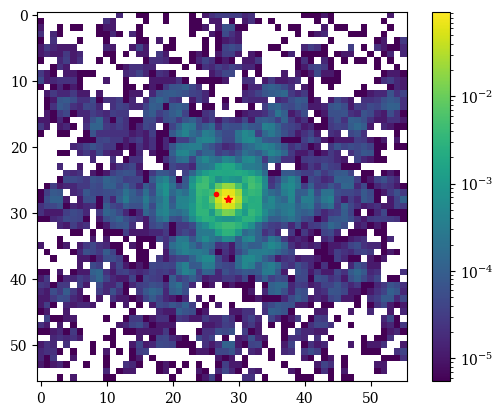

In [143]:
plt.imshow(data, norm="log")
plt.colorbar()

plt.plot(toPix(pri_x), toPix(-pri_y), marker='*', color="red")
plt.plot(toPix(sec_x), toPix(-sec_y), marker='.', color="red")
#plt.plot(toPix(source_offset_x), toPix(-source_offset_y), marker='1', color="red")

Now as we got fake data, lets tru to grid search the star position so we can pass it to the HMC as initial guess. 

In [144]:
from jax import lax

model = telescope

def likelihood(x, y, separation, angle, expected_data):
    model_data_n = model.set(['source.position', 'source.separation', 'source.position_angle'],
                           [np.array([x, y]), separation, angle]).model()
    model_data = norm(model_data_n)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared  #log likelihood
    #print(f"x={x}, y={y}, chi_squared={chi_squared}")
    return likelihood

@jit
def likelihood_fast(x, y, separation, angle, expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], args[2], args[3], expected_data)
    args = np.stack((x, y, separation, angle), axis=-1)
    return lax.map(likelihood_c, args)

In [145]:
def get_grid(xsize, xmin, xmax, ysize, ymin, ymax):
    allsize = xsize*ysize

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, xsize), np.linspace(ymin, ymax, ysize))

    xr = xx.reshape((allsize))
    yr = yy.reshape((allsize))

    return xr, yr

def grid_search(get_data, x0, y0, grid_size, grid_steps, niter = 5, oversteps = 5):
    i = 0
    x_found = None
    y_found = None
    traces = []
    
    if x0 is None:
        x0 = 0
    if y0 is None:
        y0 = 0
    
    xsteps = grid_steps
    ysteps = grid_steps
    xmin = x0 - grid_size / 2
    xmax = x0 + grid_size / 2
    ymin = y0 - grid_size / 2
    ymax = y0 + grid_size / 2
    
    while i < niter:
        
        xr, yr = get_grid(xsteps, xmin, xmax, ysteps, ymin, ymax)
        
        xstep = xr[1] - xr[0]
        ystep = yr[xsteps] - yr[0]
        
        out = get_data(xr, yr)
        
        likelihoods = np.array(out).reshape((xsteps, ysteps))

        ind_argmax = out.argmax()
        x_found = xr[ind_argmax]
        y_found = yr[ind_argmax]
        
        trace = {
            'x': x_found,
            'y': y_found,
            'xstep': xstep,
            'ystep': ystep,
            'likelihoods': likelihoods
        }
        
        xmin = x_found - xstep*oversteps
        xmax = x_found + xstep*oversteps
        ymin = y_found - ystep*oversteps
        ymax = y_found + ystep*oversteps
        
        traces.append(trace)
        i = i + 1
        #print()
        
    return x_found, y_found, traces
    
    

First we search for the position of the primary star

In [146]:
def get_single(xr, yr):
    return likelihood_fast(xr, yr, np.zeros_like(xr), np.zeros_like(xr), data)

def get_primary(xr, yr):
    if sec_xr is None or sec_yr is None:
        return likelihood_fast(xr, yr, np.zeros_like(xr), np.zeros_like(xr), data)
    x, y, s, a =  xyToSep(xr, yr, sec_xr, sec_yr)
    return likelihood_fast(x, y, s, a, data)

def get_secondary(xr, yr):
    x, y, s, a =  xyToSep(pri_xr, pri_yr, xr, yr)
    return likelihood_fast(x, y, s, a, data)

In [147]:
def print_stats(px, py, sx, sy):
    print(f'primary: {px}, {py}')
    print(f'dp: {px - pri_x}, {py - pri_y}')
    print()
    
    print(f'secondary: {sx}, {sy}')
    print(f'ds: {sx - sec_x}, {sy - sec_y}')
    print()

primary: 2.8928998733802435e-07, -1.447940814794319e-07
dp: 2.4786087704351775e-08, -2.3741873654326802e-08

secondary: -1.049248325116703e-21, -3.879652474067107e-22
ds: 2.645038996336715e-07, -1.210522078251055e-07



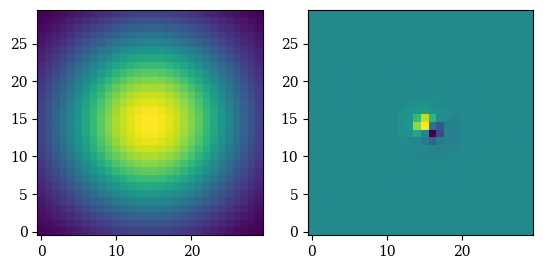

primary: 2.725722741963162e-07, -1.2807636833772374e-07
dp: 8.068374562643617e-09, -7.024160512618644e-09

secondary: -1.671771314170825e-07, 1.6717713141708094e-07
ds: 9.732676821659007e-08, 4.612492359197585e-08



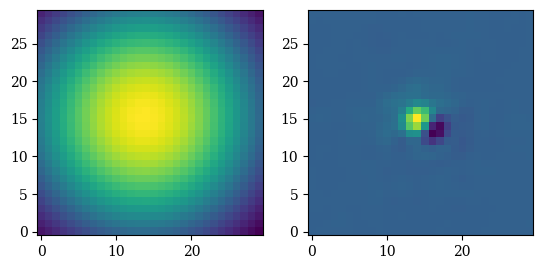

primary: 2.6142713210184407e-07, -1.1693122624325165e-07
dp: -3.0767675318285058e-09, 4.120981581853439e-09

secondary: 3.9007997330652224e-07, -6.129828151959653e-07
ds: 6.545838729401948e-07, -7.340350230210704e-07



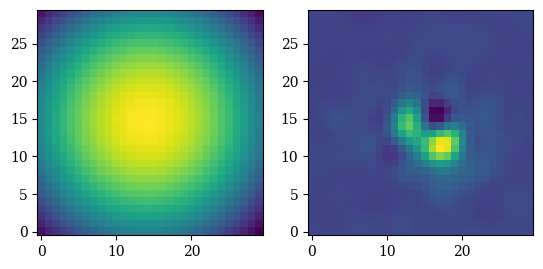

primary: 2.688572268314921e-07, -1.2436132097289972e-07
dp: 4.353327197819523e-09, -3.3091131477946295e-09

secondary: -2.786285523618033e-07, 5.5725710472360125e-08
ds: -1.4124652728130708e-08, -6.532649735274497e-08



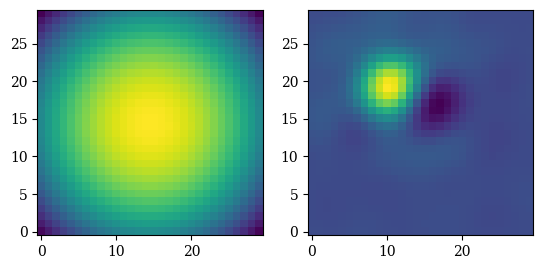

primary: 2.6390383034506004e-07, -1.194079244864677e-07
dp: -6.000692886125314e-10, 1.6442833386373986e-09

secondary: -4.272304469547646e-07, 1.0525967533668045e-07
ds: -1.6272654732109203e-07, -1.5792532488424646e-08



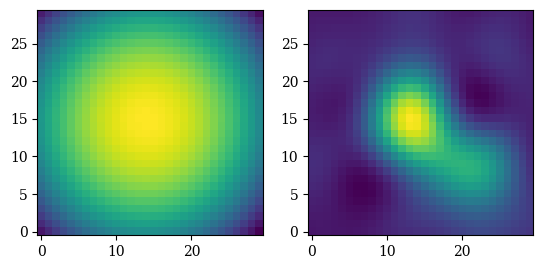

primary: 2.672060946693481e-07, -1.2271018881075573e-07
dp: 2.702195035675505e-09, -1.6579809856506378e-09

secondary: -2.6211723074036326e-07, 7.223703209380016e-08
ds: 2.3866688933093153e-09, -4.881517573130493e-08



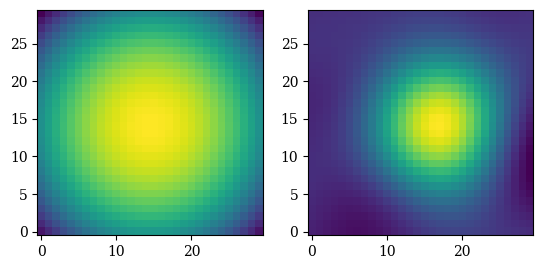

primary: 2.650045851198227e-07, -1.2050867926123037e-07
dp: 5.006854861501474e-10, 5.435285638747198e-10

secondary: -3.721927082166309e-07, 9.425212758905362e-08
ds: -1.076888085829583e-07, -2.6800080236051473e-08



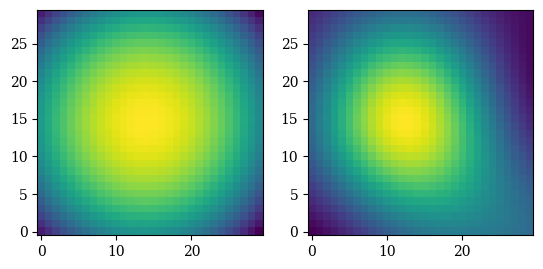

primary: 2.635369120868058e-07, -1.2197635229424727e-07
dp: -9.669875468667753e-10, -9.241444691421764e-10

secondary: -3.5751597788646186e-07, 1.3828231857956068e-07
ds: -9.301207825278928e-08, 1.7230110754455586e-08



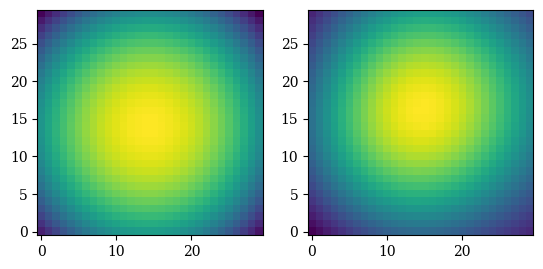

primary: 2.6451536077548375e-07, -1.2295480098292522e-07
dp: 1.1461141811173153e-11, -1.902593157820125e-09

secondary: -3.085935434525652e-07, 1.4806680546634003e-07
ds: -4.40896438188926e-08, 2.701459764123494e-08



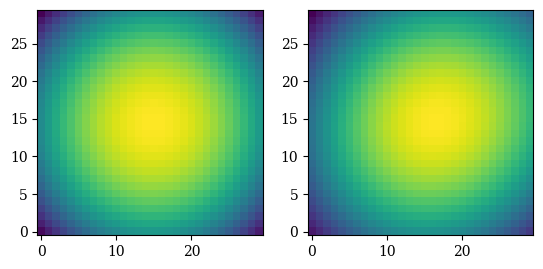

primary: 2.65167659901269e-07, -1.2230250185713993e-07
dp: 6.637602675964368e-10, -1.2502940320348347e-09

secondary: -3.151165347104181e-07, 1.1545184917707554e-07
ds: -5.0612635076745504e-08, -5.600358648029556e-09



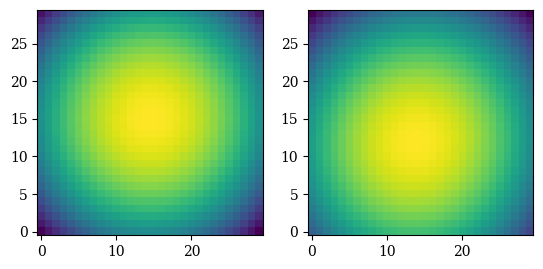

primary: 2.6473279381741213e-07, -1.2186763577328307e-07
dp: 2.288941837395591e-10, -8.154279481779834e-10

secondary: -3.3685983890326107e-07, 1.1110318833850693e-07
ds: -7.235593926958849e-08, -9.949019486598162e-09



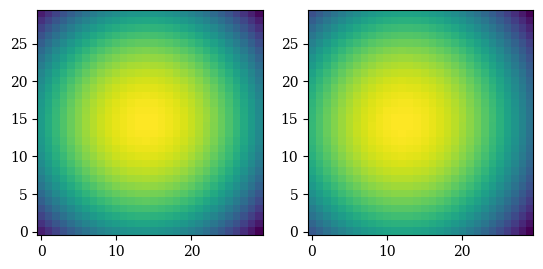

primary: 2.644428830948409e-07, -1.2215754649585433e-07
dp: -6.101653883169275e-11, -1.1053386707492353e-09

secondary: -3.3396073167754865e-07, 1.255987244670689e-07
ds: -6.945683204387608e-08, 4.546516641963821e-09



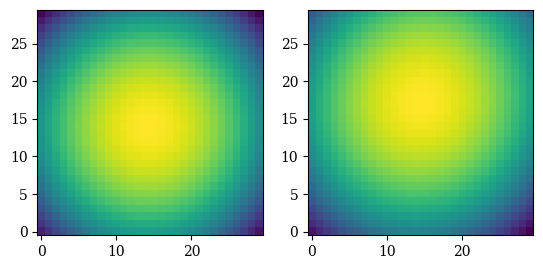

primary: 2.646361569098884e-07, -1.2235082031090182e-07
dp: 1.3225727621582613e-10, -1.2986124857967277e-09

secondary: -3.2816251722612383e-07, 1.2753146261754384e-07
ds: -6.365861759245125e-08, 6.479254792438745e-09



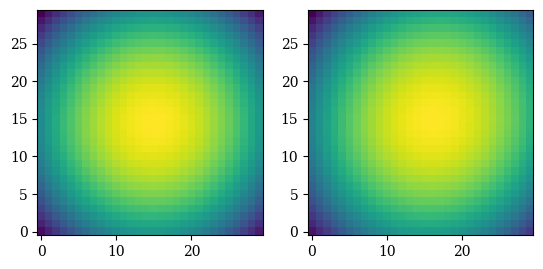

primary: 2.6450730769985674e-07, -1.2222197110087016e-07
dp: 3.408066184164525e-12, -1.169763275765066e-09

secondary: -3.3460497772770696e-07, 1.2624297051722722e-07
ds: -7.010107809403439e-08, 5.190762692122129e-09



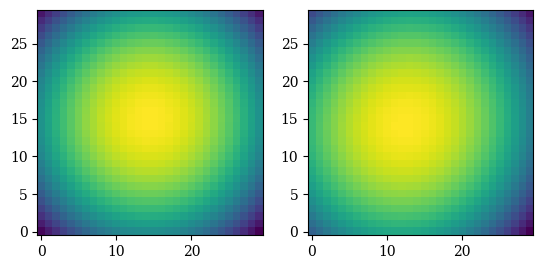

primary: 2.645932071732112e-07, -1.2213607162751573e-07
dp: 8.930753953862324e-11, -1.0838638024106338e-09

secondary: -3.3374598299416253e-07, 1.2366598631659396e-07
ds: -6.924208336048996e-08, 2.6137784914888707e-09



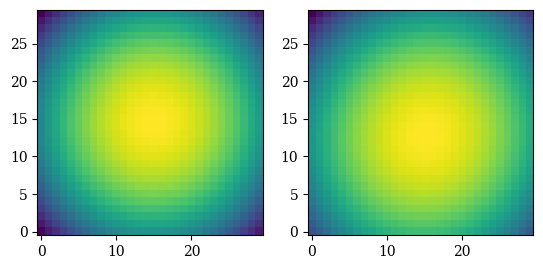

primary: 2.6465047348878084e-07, -1.2219333794308536e-07
dp: 1.4657385510826238e-10, -1.141130117980273e-09

secondary: -3.3088266721568116e-07, 1.230933231608977e-07
ds: -6.637876758200858e-08, 2.0411153357926116e-09



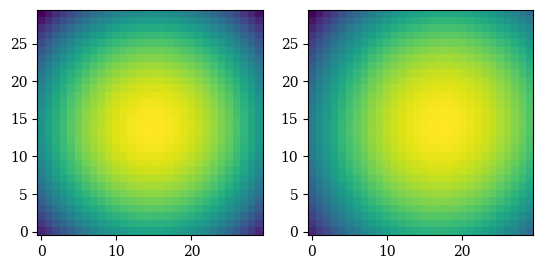

primary: 2.6461229594506775e-07, -1.2223151548679846e-07
dp: 1.0839631139516962e-10, -1.1793076616933657e-09

secondary: -3.3050089177855034e-07, 1.2500220034655197e-07
ds: -6.599699214487776e-08, 3.949992521446879e-09



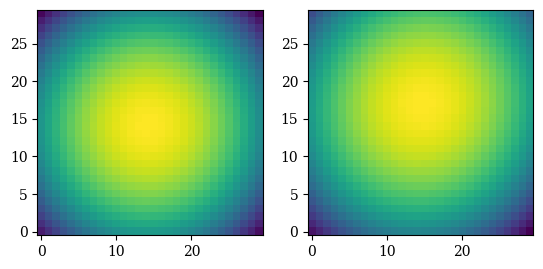

primary: 2.6463774764087646e-07, -1.2220606379098972e-07
dp: 1.3384800720388048e-10, -1.1538559658846284e-09

secondary: -3.3075540873663755e-07, 1.237296155561158e-07
ds: -6.625150910296498e-08, 2.6774077310107007e-09



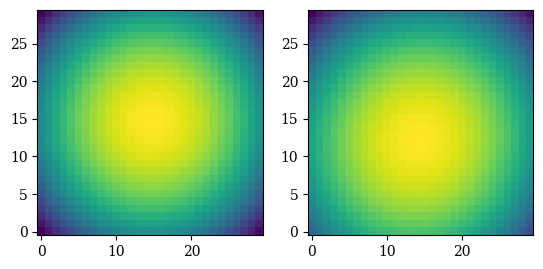

primary: 2.6462077984367067e-07, -1.2222303158819554e-07
dp: 1.1688020999809089e-10, -1.1708237630904445e-09

secondary: -3.305857307645794e-07, 1.2457800541640657e-07
ds: -6.608183113090682e-08, 3.5257975913014775e-09



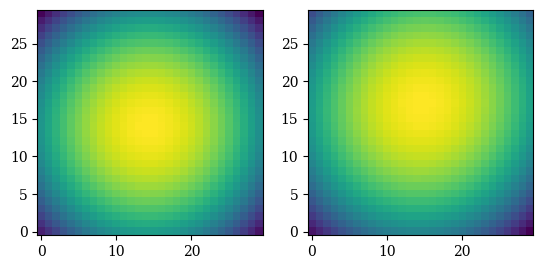

primary: 2.646320917084745e-07, -1.2223434345299942e-07
dp: 1.2819207480195062e-10, -1.1821356278943307e-09

secondary: -3.3024637482046307e-07, 1.244648867683678e-07
ds: -6.57424751867905e-08, 3.4126789432627214e-09



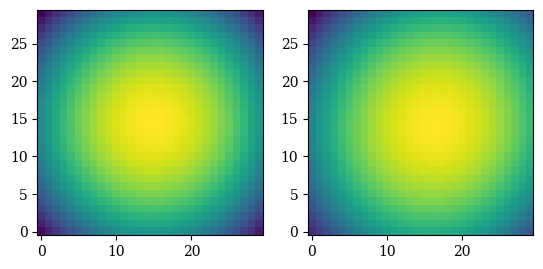

CPU times: user 6min 55s, sys: 8.44 s, total: 7min 4s
Wall time: 1min 32s


In [148]:
%%time

pri_xr = None
pri_yr = None
sec_xr = None
sec_yr = None

pri_width = toRad(0.3)
sec_width = toRad(3)
steps = 30
iters = 20

i = 0

pri_xr, pri_yr, tp = grid_search(get_primary, pri_xr, pri_yr, pri_width, steps, niter = 3)
sec_xr, sec_yr, ts = grid_search(get_secondary, sec_xr, sec_yr, sec_width, steps, niter = 1)

while i < iters:
    pri_xr, pri_yr, tp = grid_search(get_primary, pri_xr, pri_yr, pri_width, steps, niter = 1)
    sec_xr, sec_yr, ts = grid_search(get_secondary, sec_xr, sec_yr, sec_width, steps, niter = 1)

    print_stats(pri_xr, pri_yr, sec_xr, sec_yr)
    
    
    plt.subplot(1, 2, 1)
    plt.imshow(tp[0]['likelihoods'], origin='lower')
    
    plt.subplot(1, 2, 2)
    plt.imshow(ts[0]['likelihoods'], origin='lower')
    
    plt.show()
    
    pri_width = pri_width * 2 / 3
    sec_width = sec_width * 2 / 3
    
    i += 1


In [149]:
mean_xr, mean_yr, separation_rec, angle_rec =  xyToSep(pri_xr, pri_yr, sec_xr, sec_yr)

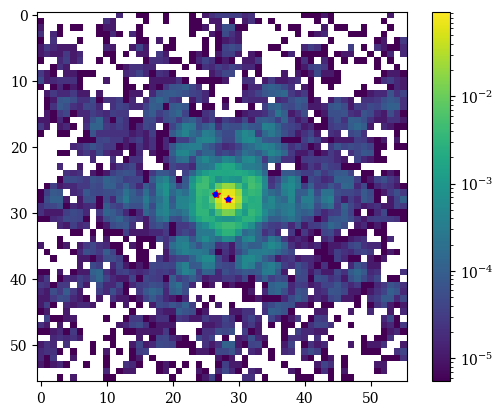

In [150]:
plt.imshow(data, norm="log")

plt.plot(toPix(pri_x), toPix(-pri_y), marker='*', color="red")
plt.plot(toPix(sec_x), toPix(-sec_y), marker='*', color="red")
plt.plot(toPix(pri_xr), toPix(-pri_yr), marker='.', color="blue")
plt.plot(toPix(sec_xr), toPix(-sec_yr), marker='.', color="blue")
#plt.plot(toPix(mean_xr), toPix(-mean_yr), marker='1', color="blue")

plt.colorbar()

In [151]:

print(toArcsec(pri_x - pri_xr))
print(toArcsec(pri_y - pri_yr))

print(toArcsec(sec_x - sec_xr))
print(toArcsec(sec_y - sec_yr))


print(toArcsec(mean_xr))
print(toArcsec(mean_yr))

print(toArcsec(separation_rec - separation))
print(angle_rec - position_angle)

-2.6441513471437627e-05
0.00024383297624541372
0.01356035890660788
-0.0007039155610156308
-0.006766958696568222
0.00023004129238510853
0.012835319944960006
-0.03608497273626643


## Step 3: Set up HMC parameters and distributions.

In [152]:
flux = np.sum(data)
log_flux = np.log(flux)
print(log_flux)

std = np.std(bg_noise)
print(std)

6.661338147750917e-15
0.009875399174576143


In [153]:
std = 0.01 * np.ones_like(data.flatten())

coord_range = toArcsec(4 * pixscale)
log_flux_range = 0.5

x0 = toArcsec(mean_xr)
y0 = toArcsec(mean_yr)
s0 = toArcsec(separation_rec)

smin = max(0, s0 - coord_range)

In [154]:
coord_range

0.25200000000000006

In [155]:
import numpyro as npy
import numpyro.distributions as dist

parameters = ['source.position', 'source.separation', 'source.position_angle']

def psf_model(data, data_err, model):
    """
    Define the numpyro function
    """
    
    x_sample = npy.sample("x_arcsec", dist.Uniform(x0 - coord_range, x0 + coord_range))
    y_sample = npy.sample("y_arcsec", dist.Uniform(y0 - coord_range, y0 + coord_range))
    separation_sample = npy.sample("sep_arcsec", dist.Uniform(smin, s0 + coord_range))
    angle_sample = npy.sample("angle_deg", dist.Uniform(angle_rec - np.pi/8, angle_rec + np.pi/8)) # !! Not deg, rad
    
    #flux_sample  = npy.sample("log_flux", dist.Uniform(log_flux - log_flux_range, log_flux + log_flux_range))
    
    #det_flux = np.exp(flux_sample)
    
    det_x = toRad(x_sample)
    det_y = toRad(y_sample)
    det_separation = toRad(separation_sample)
    det_angle = angle_sample
    
    values = [
        np.array([det_x, det_y]),
        det_separation, 
        det_angle
    ]
    
    with npy.plate("data", len(data.flatten())):
        dist_model = dist.Normal(model.set(parameters, values).model().flatten(), data_err)
        npy.sample("psf", dist_model, obs=data.flatten())

In [191]:
from jax import device_count

initial_values = {
    "x_arcsec": x0,
    "y_arcsec": y0,
    "sep_arcsec": s0,
    "angle_deg": angle_rec
    
    #"log_flux": log_flux
}

sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model, init_strategy=npy.infer.init_to_value(values=initial_values)),    #init_strategy=npy.infer.init_to_value(values=initial_values)
    num_warmup=1000,
    num_samples=1000,
    num_chains=device_count(),
    progress_bar=True,
)
%time sampler.run(jr.PRNGKey(0), data_n, std, telescope)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 18h 29min 57s, sys: 39min 51s, total: 19h 9min 49s
Wall time: 7h 20min 2s


Step 4: Make plots.

In [192]:
sampler.print_summary()
values_out = sampler.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
   angle_deg      1.96      0.00      1.96      1.96      1.96    461.46      1.01
  sep_arcsec      0.11      0.00      0.11      0.11      0.11   1412.80      1.00
    x_arcsec      0.00      0.00      0.00      0.00      0.00   1022.09      1.00
    y_arcsec     -0.00      0.00     -0.00     -0.00     -0.00    526.45      1.01

Number of divergences: 0


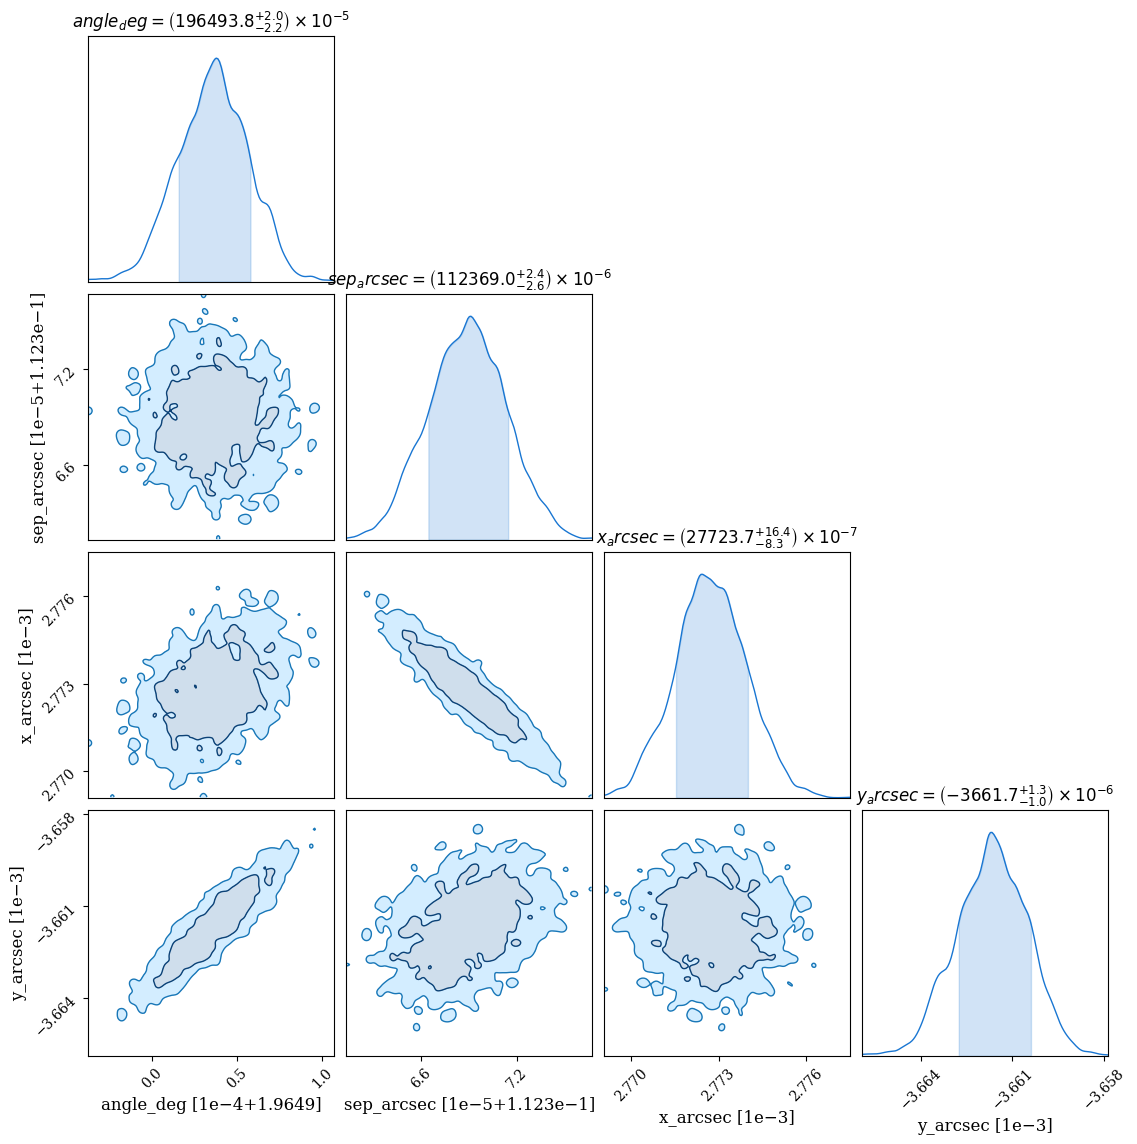

In [193]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)

fig = chain.plotter.plot()
fig.set_size_inches((12, 12));

array([[<Axes: title={'center': 'angle_deg'}>,
        <Axes: title={'center': 'angle_deg'}>],
       [<Axes: title={'center': 'sep_arcsec'}>,
        <Axes: title={'center': 'sep_arcsec'}>],
       [<Axes: title={'center': 'x_arcsec'}>,
        <Axes: title={'center': 'x_arcsec'}>],
       [<Axes: title={'center': 'y_arcsec'}>,
        <Axes: title={'center': 'y_arcsec'}>]], dtype=object)

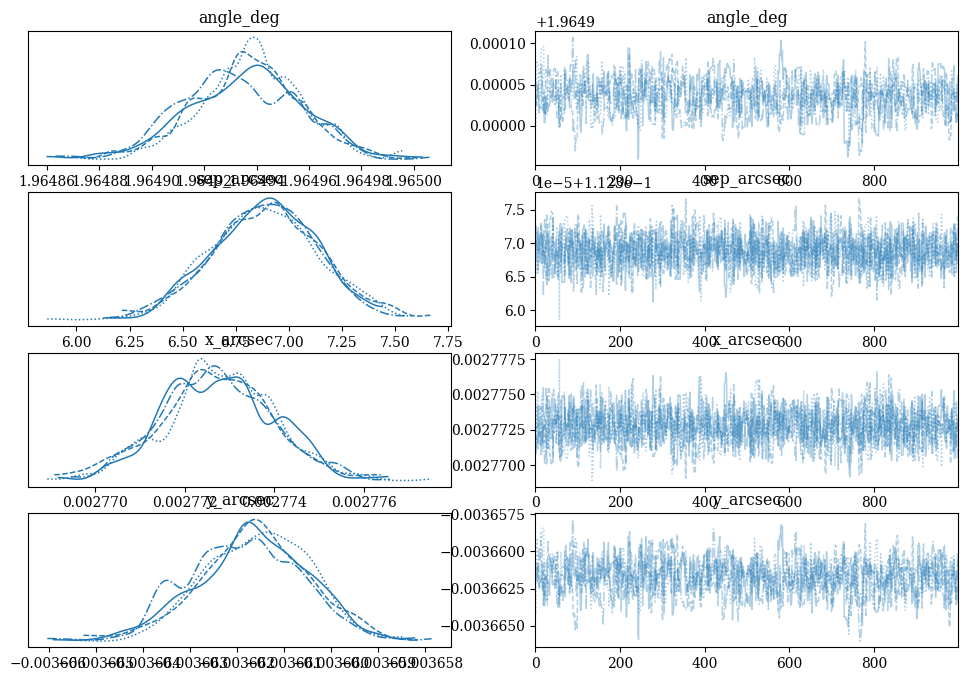

In [194]:

import arviz as az
az.plot_trace(az.from_numpyro(sampler))

In [195]:
lls = log_likelihood(psf_model, values_out, data, std, telescope)['psf']

In [196]:
lls.shape

(4000, 3136)

In [197]:
def get_ll(x, y, sep, angle):
    values = {
        "x_arcsec": np.array(x),
        "y_arcsec": np.array(y),
        "sep_arcsec": np.array(sep),
        "angle_deg": np.array(angle)
    }
    return log_likelihood(psf_model, values, data, std, telescope)['psf'].sum()

#get_ll(values_out['x'][0], values_out['y'][0])

grad_ll = jax.grad(get_ll, argnums=[0,1,2,3])

grad_values = grad_ll(values_out['x_arcsec'], values_out['y_arcsec'], values_out['sep_arcsec'], values_out['angle_deg'] )


In [198]:
grad_x, grad_y, grad_sep, grad_angle = grad_values

In [199]:
print(grad_x.shape)
print(grad_x)

(4000,)
[16883895.32800885 16883784.77419981 16884243.37753463 ...
 16884257.3158116  16883956.93906228 16883978.22835579]


Text(0.5, 1.0, 'grad_angle')

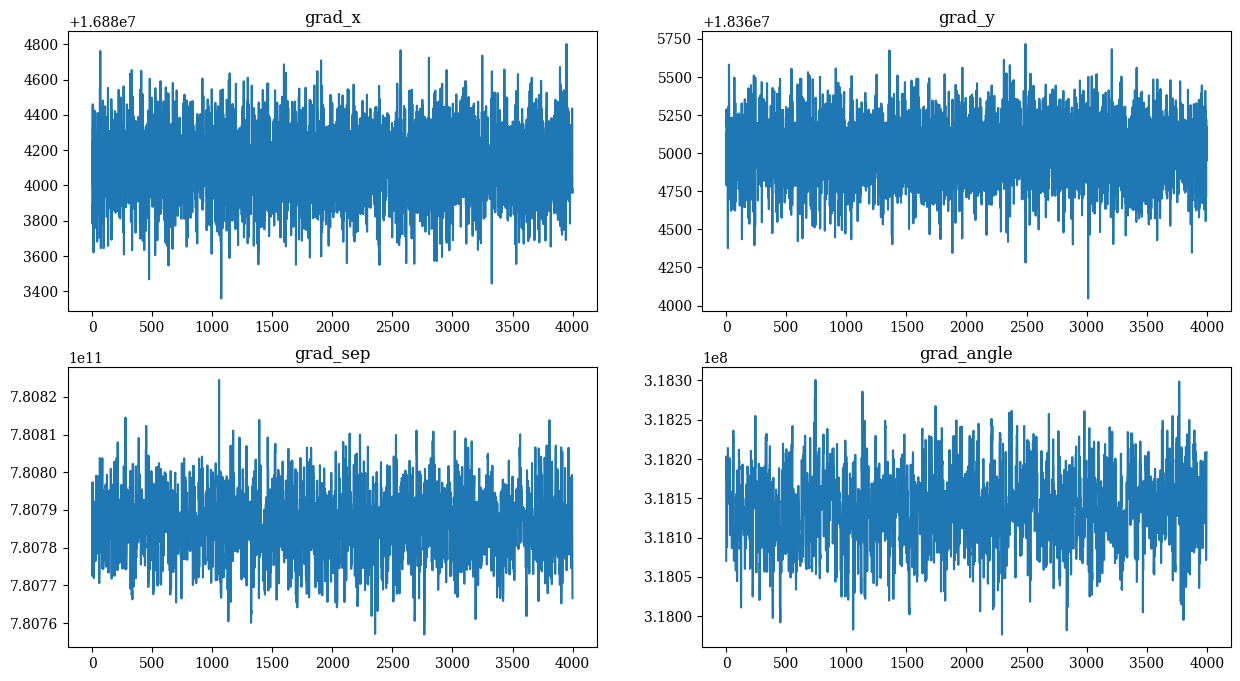

In [200]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.plot(grad_x)
plt.title('grad_x')

plt.subplot(2, 2, 2)
plt.plot(grad_y)
plt.title('grad_y')

plt.subplot(2, 2, 3)
plt.plot(grad_sep)
plt.title('grad_sep')

plt.subplot(2, 2, 4)
plt.plot(grad_angle)
plt.title('grad_angle')